# Fitbit Data Analysis 🏃‍♂️📊
# View 1: Detailed Workout Analysis (plot_performance_timeline)

In [1]:
import json
import gzip
import pandas as pd
from datetime import datetime, timedelta
import boto3
from io import BytesIO

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter
import seaborn as sns

#### =============================================================================
## Bucket

In [3]:
session = boto3.Session(profile_name='surface')
s3 = session.client('s3')

In [4]:
bucket_name = 'followcrom'
prefix = 'cromwell/fitbit/'

#### =============================================================================
## Files

In [5]:
s3response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
files = [obj['Key'] for obj in s3response.get('Contents', [])]
files

['cromwell/fitbit/',
 'cromwell/fitbit/fitbit_backup_2025-10-03.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-04.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-05.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-06.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-07.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-08.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-09.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-10.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-11.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-12.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-13.json.gz',
 'cromwell/fitbit/fitbit_backup_2025-10-14.json.gz']

#### =============================================================================
## Select Date

In [38]:
file_key = 'cromwell/fitbit/fitbit_backup_2025-10-08.json.gz'

In [39]:
response = s3.get_object(Bucket=bucket_name, Key=file_key)
with gzip.GzipFile(fileobj=BytesIO(response['Body'].read())) as f:
    data = json.load(f)
print(f"Loaded {len(data):,} records")

Loaded 35,913 records


#### =============================================================================
## All DFs

In [40]:
from functions.parse_data import parse_fitbit_data

In [41]:
# Parse all data
dfs = parse_fitbit_data(data)

# Display summary
print("\n📊 Available DataFrames:")
print("="*60)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records | Columns: {list(df.columns)}")


📊 Available DataFrames:
HeartRate_Intraday             |  34407 records | Columns: ['time', 'Device', 'value']
Steps_Intraday                 |   1440 records | Columns: ['time', 'Device', 'value']
HRV                            |      1 records | Columns: ['time', 'Device', 'dailyRmssd', 'deepRmssd']
BreathingRate                  |      1 records | Columns: ['time', 'Device', 'value']
SkinTemperature                |      1 records | Columns: ['time', 'Device', 'nightlyRelative']
SPO2_Daily                     |      1 records | Columns: ['time', 'Device', 'avg', 'max', 'min']
Activity-minutesSedentary      |      1 records | Columns: ['time', 'Device', 'value']
Activity-minutesLightlyActive  |      1 records | Columns: ['time', 'Device', 'value']
Activity-minutesFairlyActive   |      1 records | Columns: ['time', 'Device', 'value']
Activity-minutesVeryActive     |      1 records | Columns: ['time', 'Device', 'value']
Activity-steps                 |      1 records | Columns: ['time

#### =============================================================================
## DFs

In [60]:
df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())
df_steps_intra = dfs.get('Steps_Intraday', pd.DataFrame())
df_activity_records = dfs.get('ActivityRecords', pd.DataFrame())

print(f"✅ Found {len(df_hr_intra)} HeartRate_Intraday records")
print(f"✅ Found {len(df_steps_intra)} Steps records")
print(f"✅ Found {len(df_activity_records)} Activity records")

✅ Found 34407 HeartRate_Intraday records
✅ Found 1440 Steps records
✅ Found 2 Activity records


In [61]:
date = df_activity_records['time']
date

0   2025-10-08 20:01:12+00:00
1   2025-10-08 21:01:32+00:00
Name: time, dtype: datetime64[ns, UTC]

In [62]:
print("Steps_Intraday Timezone:", df_steps['time'].dt.tz)
print("ActivityRecords Timezone:", df_activity_steps['time'].dt.tz)

Steps_Intraday Timezone: UTC
ActivityRecords Timezone: UTC


In [45]:
# df_activity_records['time'] = df_activity_records['time'].dt.tz_convert('Europe/London')

In [46]:
# df_activity_records['time'] = df_activity_records['time'].dt.tz_convert('UTC')

In [47]:
print("HeartRate_Intraday Timezone:", df_hr_intra['time'].dt.tz)
print("Steps_Intraday Timezone:", df_steps_intra['time'].dt.tz)
print("ActivityRecords Timezone:", df_activity_records['time'].dt.tz)

HeartRate_Intraday Timezone: UTC
Steps_Intraday Timezone: UTC
ActivityRecords Timezone: UTC


In [55]:
print(df_activity_records[['time', 'ActivityName', 'calories', 'distance', 'steps', 'speed', 'pace', 'averageHeartRate', 'duration', 'activeDuration', 'inProgress', 'originalDuration', 'elevationGain', 'hasActiveZoneMinutes', 'cl']].to_string())

                       time ActivityName  calories  distance   steps     speed         pace  averageHeartRate   duration  activeDuration  inProgress  originalDuration  elevationGain  hasActiveZoneMinutes       cl
0 2025-10-08 20:01:12+00:00         Swim     366.0  1.304880     NaN  1.519757  2368.800196               NaN  3091000.0       3091000.0         0.0         3091000.0            0.0                   1.0      NaN
1 2025-10-08 21:01:32+00:00         Walk     173.0  0.807845  1648.0  2.028063  1775.092994             104.0  1434000.0       1434000.0         0.0         1434000.0          120.0                   1.0  15.9699


In [49]:
# Define heart rate zones
zones = {
    'Out of Range': {'range': (0, 93), 'color': '#e8f4f8'},
    'Fat Burn': {'range': (93, 128), 'color': '#fff4e6'},
    'Cardio': {'range': (128, 155), 'color': '#ffe8e8'},
    'Peak': {'range': (155, 220), 'color': '#ffe0e0'}
}

In [50]:
import matplotlib.dates as mdates
import numpy as np
from matplotlib.patches import Rectangle

def plot_performance_timeline(df_hr_intra, df_steps_intra, activity_record):
    """
    Create a detailed performance timeline for a workout session
    
    Parameters:
    - df_hr_intra: Intraday heart rate dataframe
    - df_steps_intra: Intraday steps dataframe
    - activity_record: Single row from ActivityRecords (as Series or single-row DataFrame)
    """
    
    # Extract activity details
    if isinstance(activity_record, pd.DataFrame):
        activity_record = activity_record.iloc[0]
    
    # Handle activity time - check if it has timezone info
    activity_start = pd.to_datetime(activity_record['time'])
    # if activity_start.tz is not None:
    #     activity_start = activity_start.tz_convert('Europe/London')
    # else:
    #     # If no timezone, assume it's already in London time
    #     activity_start = activity_start.tz_localize('Europe/London')
    
    # Temporary fix: subtract 1 hour
    activity_start = activity_start - pd.Timedelta(hours=1)
    
    activity_duration = activity_record['duration'] / 1000 / 60  # Convert to minutes
    activity_end = activity_start + pd.Timedelta(minutes=activity_duration)
    
    # Add buffer time for context (15 min before/after)
    buffer = pd.Timedelta(minutes=15)
    plot_start = activity_start - buffer
    plot_end = activity_end + buffer
    
    # Filter data to workout window + buffer
    hr_window = df_hr_intra[(df_hr_intra['time'] >= plot_start) & 
                            (df_hr_intra['time'] <= plot_end)].copy()
    steps_window = df_steps_intra[(df_steps_intra['time'] >= plot_start) & 
                                  (df_steps_intra['time'] <= plot_end)].copy()
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), 
                                         sharex=True, 
                                         gridspec_kw={'height_ratios': [2, 1.5, 1]})
    
    # ========================================================================
    # Panel 1: Heart Rate with Zones
    # ========================================================================
    
    # Plot zone bands
    for zone_name, zone_info in zones.items():
        ax1.axhspan(zone_info['range'][0], zone_info['range'][1], 
                   alpha=0.2, color=zone_info['color'], label=zone_name)
    
    # Highlight workout period
    ax1.axvspan(activity_start, activity_end, alpha=0.1, 
               color='green', label='Workout Period', zorder=1)
    
    # Plot heart rate
    ax1.plot(hr_window['time'], hr_window['value'], 
            color='#ff4444', linewidth=2, label='Heart Rate', zorder=5)
    
    # Add average HR line for workout period
    hr_workout = hr_window[(hr_window['time'] >= activity_start) & 
                          (hr_window['time'] <= activity_end)]
    if not hr_workout.empty:
        avg_hr = hr_workout['value'].mean()
        ax1.axhline(avg_hr, color='darkred', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f'Avg HR: {avg_hr:.0f} bpm', zorder=4)
    
    # Add activity average HR from record
    if pd.notna(activity_record['averageHeartRate']):
        recorded_avg = activity_record['averageHeartRate']
        ax1.axhline(recorded_avg, color='purple', linestyle=':', 
                   linewidth=2, alpha=0.7, 
                   label=f'Recorded Avg: {recorded_avg:.0f} bpm', zorder=4)
    
    ax1.set_ylabel('Heart Rate (bpm)', fontsize=11, fontweight='bold')
    ax1.set_title('Workout Performance Analysis', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=9, ncol=2)
    
    # ========================================================================
    # Panel 2: Steps/Activity Intensity
    # ========================================================================
    
    # Plot steps as bar chart
    if not steps_window.empty:
        ax2.bar(steps_window['time'], steps_window['value'], 
               width=0.0007,  # Adjust bar width for minute-level data
               color='#4a90e2', alpha=0.7, label='Steps per Minute')
    
    ax2.set_ylabel('Steps/min', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax2.legend(loc='upper left', fontsize=9)
    
    # ========================================================================
    # Panel 3: Workout Metrics Summary
    # ========================================================================
    
    # Hide axes for metric display
    ax3.axis('off')
    
    # Create metrics display
    metrics = []
    metrics.append(f"Activity: {activity_record['ActivityName']}")
    metrics.append(f"Duration: {activity_duration:.1f} min")
    
    if pd.notna(activity_record['calories']):
        metrics.append(f"Calories: {activity_record['calories']:.0f} kcal")
    
    if pd.notna(activity_record['distance']):
        metrics.append(f"Distance: {activity_record['distance']:.2f} km")
    
    if pd.notna(activity_record['steps']):
        metrics.append(f"Steps: {activity_record['steps']:.0f}")
    
    if pd.notna(activity_record['pace']):
        # Convert pace from ms to min/km
        pace_min_km = activity_record['pace'] / 60000
        metrics.append(f"Pace: {pace_min_km:.2f} min/km")
    
    if pd.notna(activity_record['speed']):
        metrics.append(f"Speed: {activity_record['speed']:.2f} km/h")
    
    if pd.notna(activity_record['elevationGain']):
        metrics.append(f"Elevation: {activity_record['elevationGain']:.0f} m")
    
    # Display metrics in a grid
    metrics_text = "  |  ".join(metrics)
    ax3.text(0.5, 0.5, metrics_text, 
            transform=ax3.transAxes,
            fontsize=11,
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=1', 
                     facecolor='lightblue', 
                     alpha=0.3,
                     edgecolor='steelblue',
                     linewidth=2))
    
    # ========================================================================
    # Formatting
    # ========================================================================
    
    # Format x-axis with time labels
    for ax in [ax1, ax2]:
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz='Europe/London'))
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
        ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    
    ax2.set_xlabel('Time', fontsize=11, fontweight='bold')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    return fig

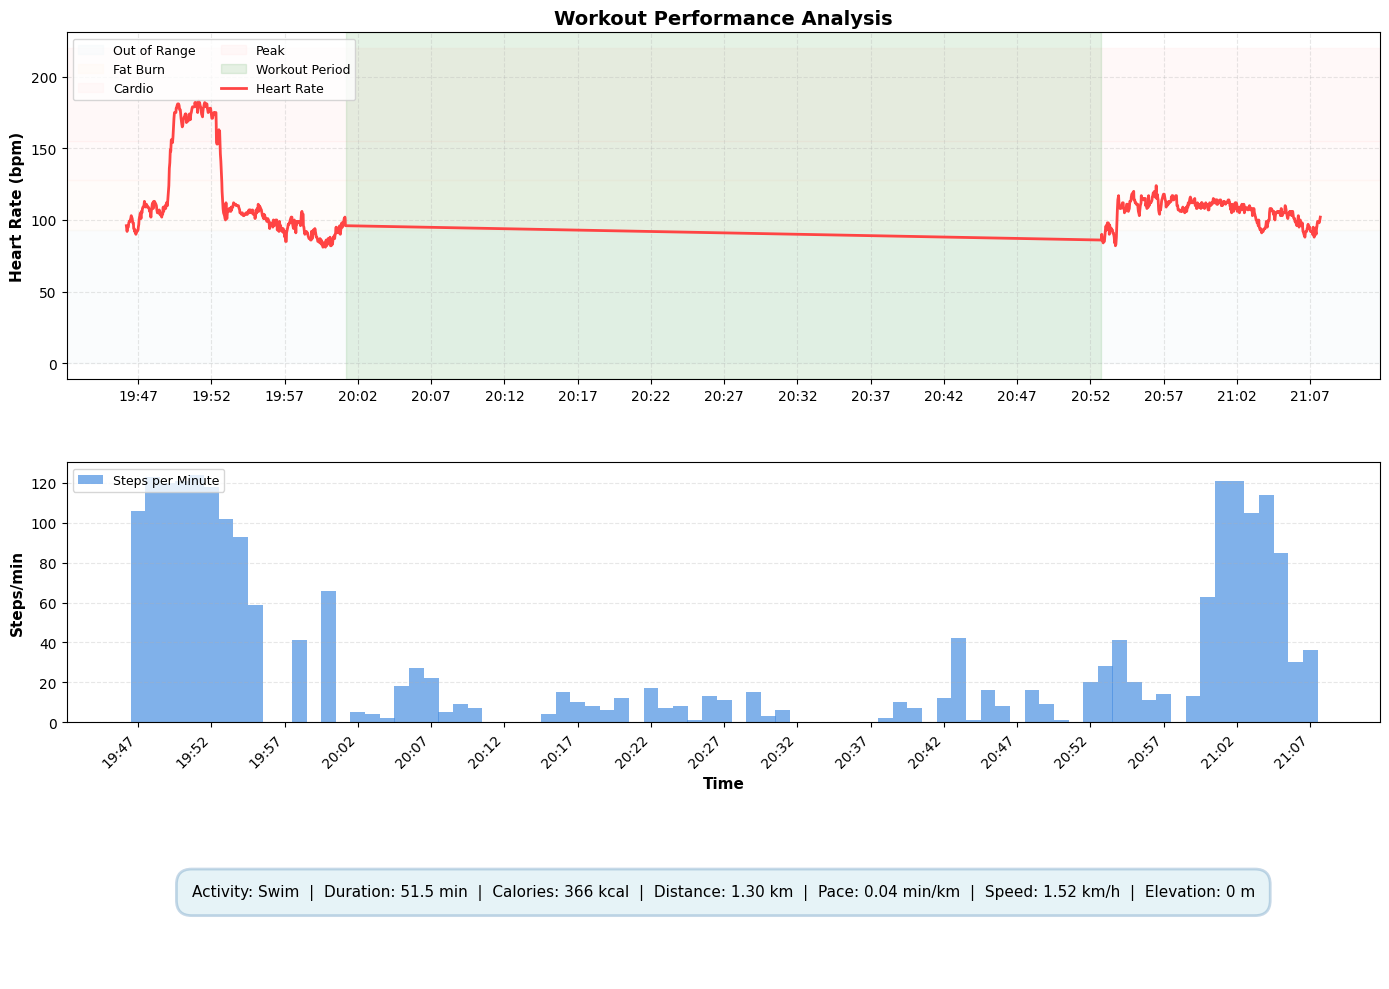

In [63]:
# Detailed workout zoom:
fig1 = plot_performance_timeline(df_hr_intra, df_steps_intra, df_activity_records)
plt.show()

In [52]:
def plot_full_day_with_workout_highlight(df_hr_intra, df_steps_intra, activity_record):
    """
    Show full day context with workout highlighted
    """
    
    if isinstance(activity_record, pd.DataFrame):
        activity_record = activity_record.iloc[0]
    
    # Convert ALL dataframes to London timezone
    # df_hr_intra = df_hr_intra.copy()
    # df_hr_intra['time'] = df_hr_intra['time'].dt.tz_convert('Europe/London')
    
    # df_steps_intra = df_steps_intra.copy()
    # df_steps_intra['time'] = df_steps_intra['time'].dt.tz_convert('Europe/London')
    
    # Handle activity time - check if it has timezone info
    activity_start = pd.to_datetime(activity_record['time'])
    # if activity_start.tz is not None:
    #     activity_start = activity_start.tz_convert('Europe/London')
    # else:
    #     # If no timezone, assume it's already in London time
    #     activity_start = activity_start.tz_localize('Europe/London')
    
    # Temporary fix: subtract 1 hour
    activity_start = activity_start - pd.Timedelta(hours=1)
    
    activity_duration = activity_record['duration'] / 1000 / 60
    activity_end = activity_start + pd.Timedelta(minutes=activity_duration)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Panel 1: Full day heart rate
    ax1.plot(df_hr_intra['time'], df_hr_intra['value'], 
            color='#ff4444', linewidth=1, alpha=0.7)
    ax1.axvspan(activity_start, activity_end, alpha=0.3, 
               color='green', label='Workout')
    ax1.set_ylabel('Heart Rate (bpm)', fontweight='bold')
    ax1.set_title('Full Day Context', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend()
    
    # Panel 2: Full day steps
    ax2.bar(df_steps_intra['time'], df_steps_intra['value'],
           width=0.0007, color='#4a90e2', alpha=0.5)
    ax2.axvspan(activity_start, activity_end, alpha=0.3, 
               color='green')
    ax2.set_ylabel('Steps/min', fontweight='bold')
    ax2.set_xlabel('Time', fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz='Europe/London'))
    ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    return fig

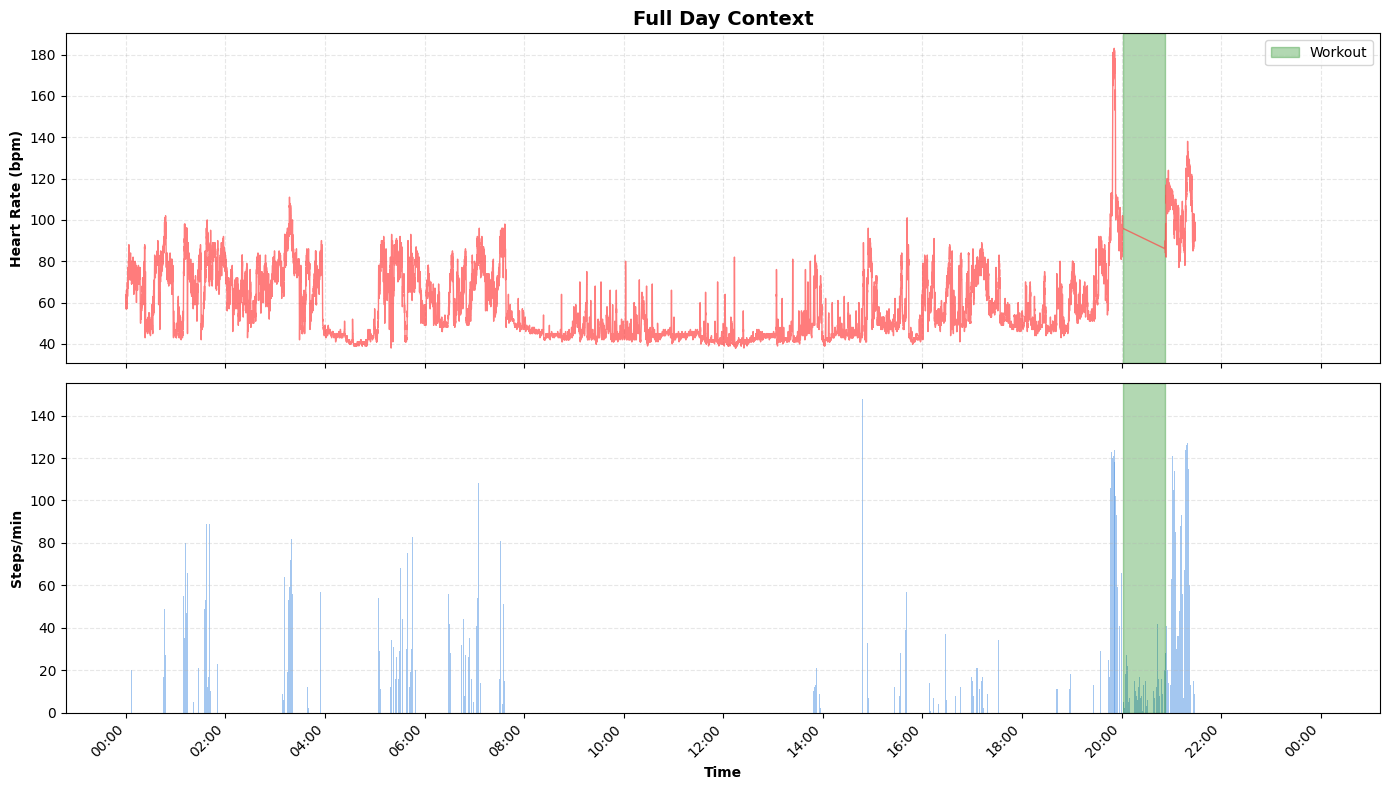

In [53]:
# Full day context:
fig2 = plot_full_day_with_workout_highlight(df_hr_intra, df_steps_intra, df_activity_records)
plt.show()